The function transformation project.

We have the basic idea that two polynomial functions which are shared some paremeters in common can share some information together, and this project is to find the visualized and quantizable relationship between the two functions. One way is to use neural network to train one function fitting for the other. 

Built a toy program to test if this method is workable.
We generate two functions and add the fixed parameters in the two functions.
Import packages which we need to use, to be convenient, i import all the package below for the whole project, some functions of the package will be used at very late. 

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.models import load_model
from sklearn import preprocessing
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import linear_model
import pandas as pd
matplotlib.rcParams.update({'font.size': 12})
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


Using TensorFlow backend.


Firstly, we generate two polynomial functions y1 and y2, and set the input data x in range (0,10) with 100 equally separated points.

In [8]:
x = np.linspace(0,1,100)
def function_gen(x, a, b, c, d, e, f, g):
    y1 = a*(x-e)**3 + b*(x-f)**2+c*(x-g)+d
    y2 = d*(x-g)**2 + c*x +a
    return y1, y2

We set the coefficient a,b,c,d normal distribution, e,f,g are randomly generated but fixed. So for each data node has 100 features and we genearted 10000 datasize for y1 and y2.

In [ ]:
y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = np.random.uniform(0,2)
f = np.random.uniform(0,2)
g = np.random.uniform(0,2)
for i in range(10000):
    a_ = np.random.normal(8, 1.5, 1)
    b_ = np.random.normal(2, 2, 1)
    c_ = np.random.normal(4, 1, 1)
    d_ = np.random.normal(0, 0.5, 1)   
    y1_, y2_ = function_gen(x, a_, b_, c_, d_, e, f, g)
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)

For a single data, we plot the figure to show how y1, y2 looks like.

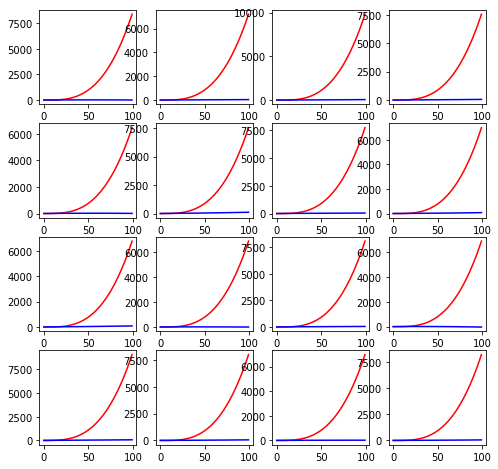

In [108]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1.shape[0])
        ax = axs[i,j]
        ax.plot(y1[k],'r-')
        ax.plot(y2[k],'b-')

Distribution of a, b, c, d are below:

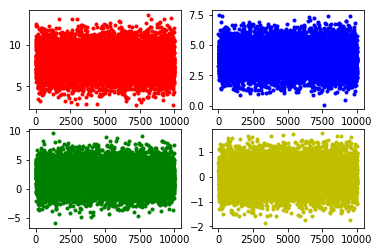

In [34]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs[0,0].plot(np.asarray(a),'r.')
axs[1,0].plot(np.asarray(b),'g.')
axs[0,1].plot(np.asarray(c),'b.')
axs[1,1].plot(np.asarray(d),'y.')

Y1 function is the third power of x, y2 is the square of x, so the function y1 contains more information than y2, so we use y1 to fit for y2. The method we used is long short-term memory recurrent neural network. 
So firstly, we need to build the structure of the RNN, a RNN structure formed by encoding layer, decoding layer and  embedding layer.

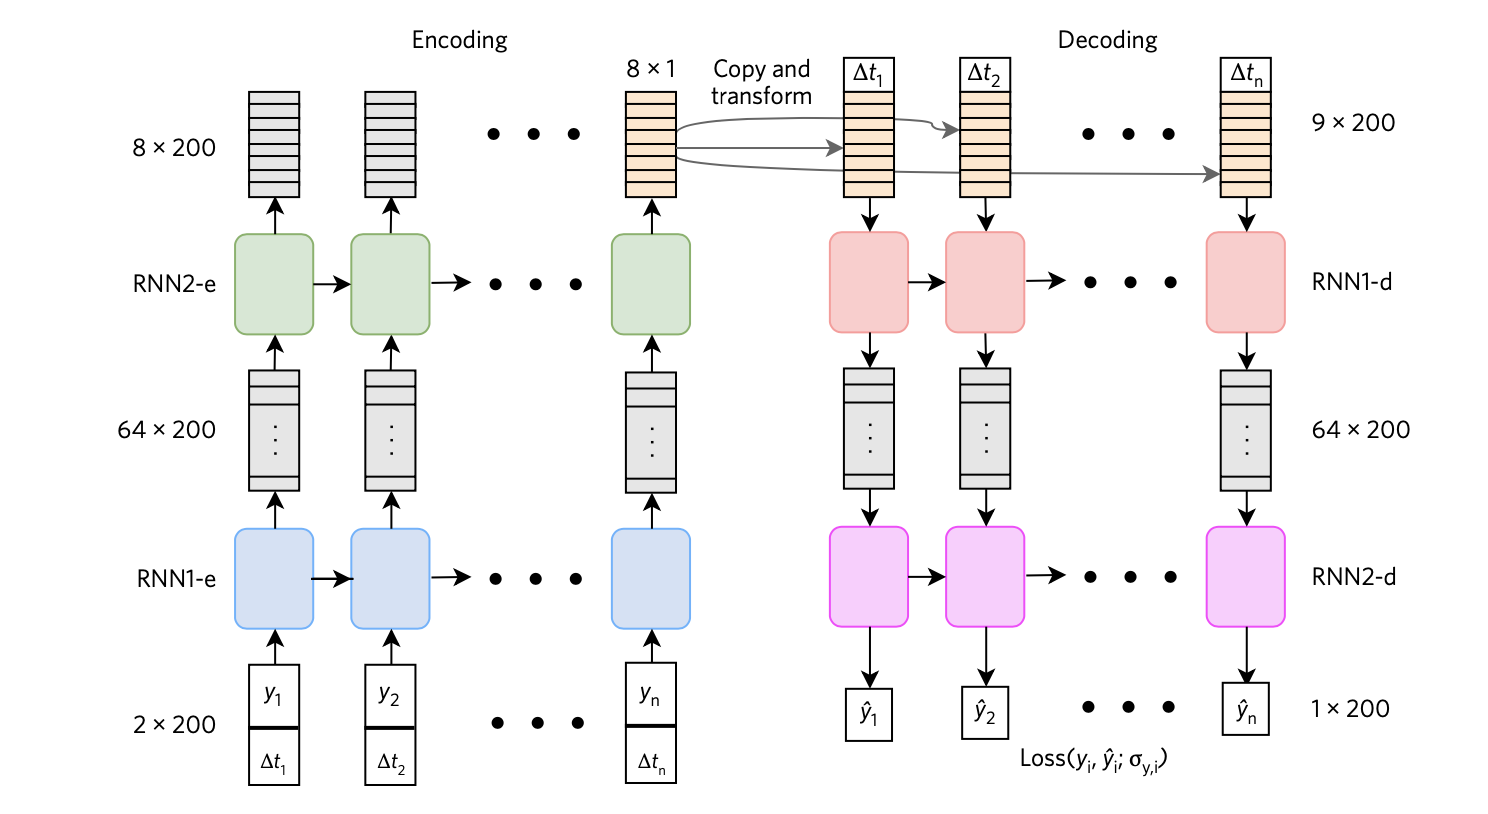

RNN encoder–decoder architecture 
This network uses two RNN layers of size 64 for encoding and two for decoding, with a feature embedding size of 8. The sampling times are passed to both the encoder and decoder; the feature vector characterizes the functional form of the signal, but the sampling times are needed to determine the points at which that function should be evaluated.

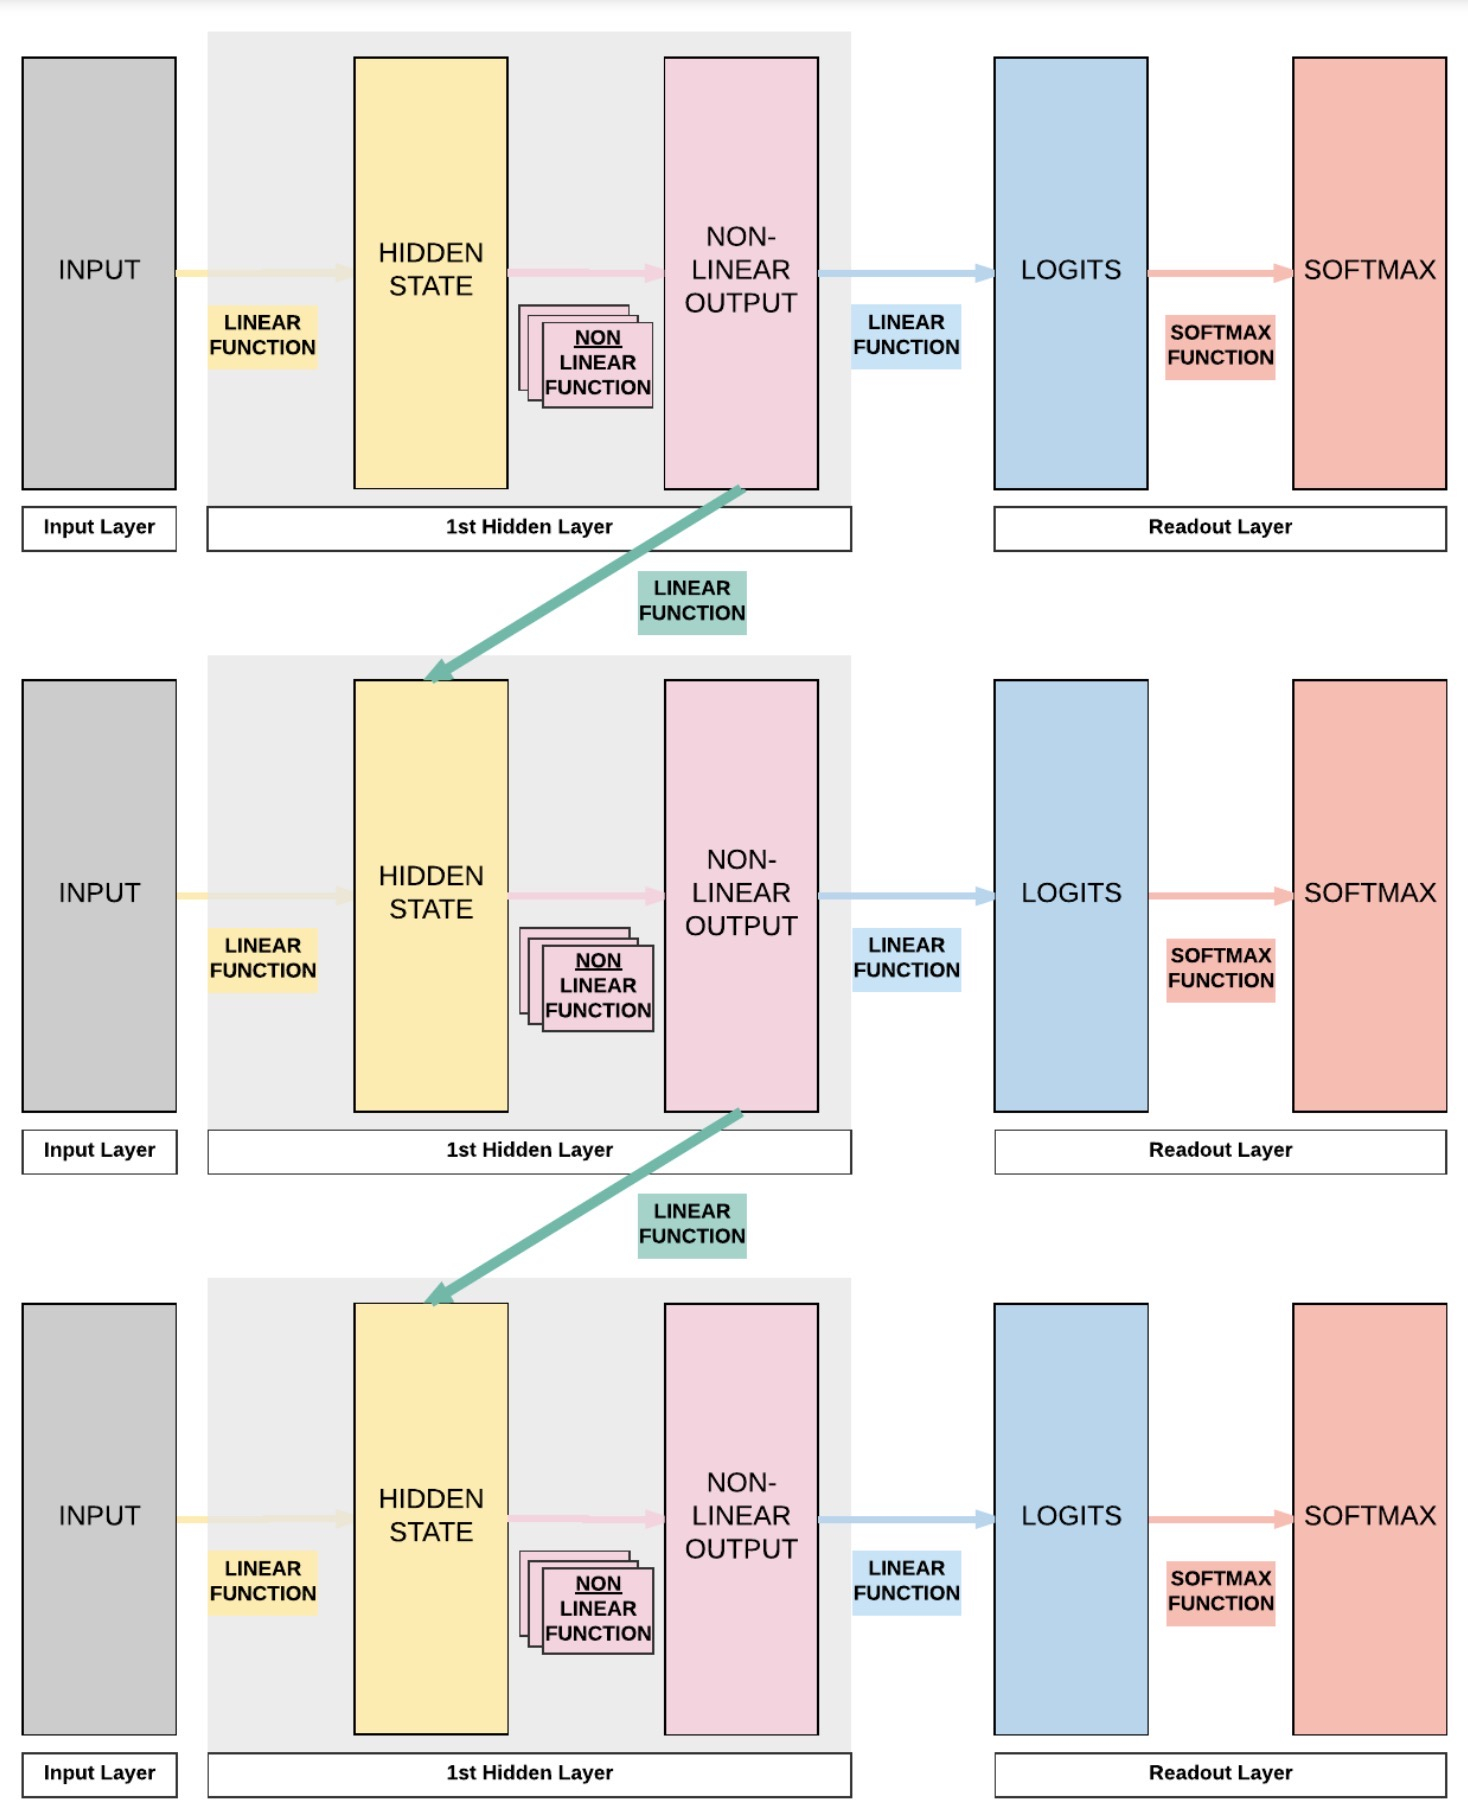

In [ ]:
def auto_test( layer = LSTM, size = 256, num_encode_layers = 3 , num_decode_layers = 3, embedding = 32, n_step = 100, lr = 1e-5, drop_frac=0.,bidirectional=True, l1_norm = 1e-4, **kwargs):
    model = Sequential()
    if bidirectional:
        wrapper = Bidirectional
        # builds the first layer
        model.add(Bidirectional(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac),
                            input_shape=(n_step, 1)))
    else:
        wrapper = lambda x: x
        # builds the first layer
        model.add(wrapper(layer(size, return_sequences=(num_encode_layers > 1),  dropout=drop_frac,
                input_shape=(n_step, 1))))
        
    for i in range(1, num_encode_layers):
        model.add(wrapper(layer(size, return_sequences=(i < num_encode_layers - 1), dropout=drop_frac)))

    # builds the embedding layer
    if l1_norm == None:
        # embedding layer without l1 regulariization
        model.add(Dense(embedding, activation='relu', name='encoding'))
    else:
        # embedding layer with l1 regularization
        model.add(Dense(embedding, activation='relu', name='encoding',activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(n_step))

    # builds the decoding layer
    for i in range(num_decode_layers):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model 

Firstly we don’t normalize the y1, y2, the coding part are below:

In [ ]:
auto_test = rnn_auto(LSTM, 128, 2, 2, 10, 100)
auto_test.fit(np.atleast_3d(y1), np.atleast_3d(y2), epochs=10000, batch_size=128)
y1_results = auto_test.predict(np.atleast_3d(y1))

In [ ]:
After the learning, the figure looks like:

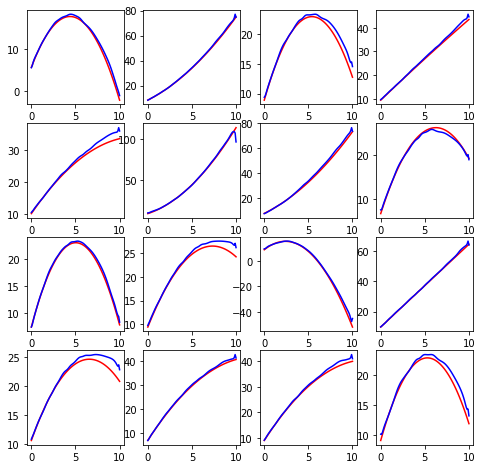

In [54]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, y1_results.shape[0])
        ax = axs[i,j]
        ax.plot(x,y2[k],'r-')
        ax.plot(x,y1_results[k],'b-')
        

After 10000 epoch, the loss = 4.7，which is not low enough.
Then, we normalized the y1, y2

In [ ]:
nor_y1 = preprocessing.normalize(y1)
nor_y2 = preprocessing.normalize(y2)

In [ ]:
auto_test = rnn_auto(LSTM, 128, 3, 3, 10, 100)
auto_test.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs=2500, batch_size=128)
nor_y1_results = auto_test.predict(np.atleast_3d(nor_y1))

And we generate the figure below:

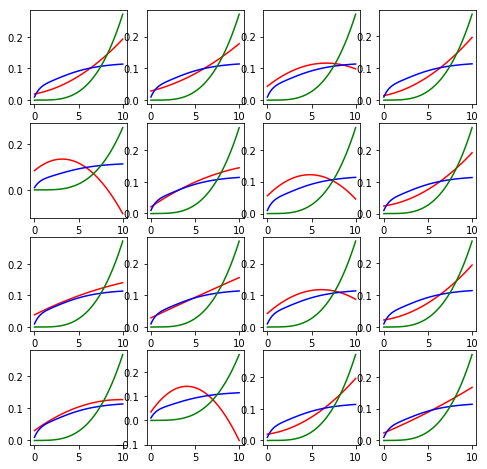

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, nor_y1_results.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y2[k],'r-')
        ax.plot(x,nor_y1_results[k],'b-')
        ax.plot(x,nor_y1[k],'g-')

Red line is normalized y2, blue line is normalized fitted y1, green line is normalized y1. For these data points, after normalized, the loss became very low, this is because the normalized y1, y2 become similar to each other since they share some parameters with the same distribution.
But it can be seen that, it’s not fitted well compared with unnormalized data.
Then, we changed the range of x from (0,10) to (0,1):

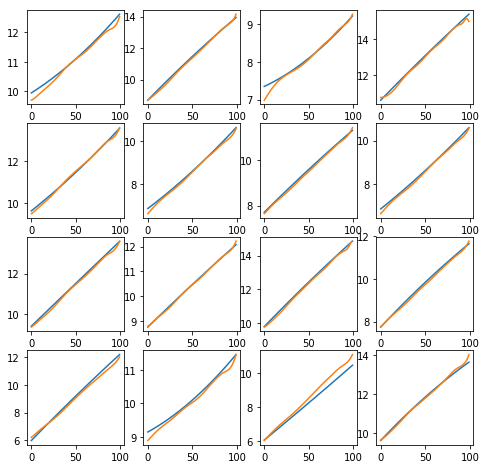

In [24]:
The results look better than the previous one, so after the training, the y1 can fit y2 very well.

After using the toy function for training, we changed the polynomial functions become more complicated structures, adding more parameters, and the difference between two functions is the shift for x:

In [ ]:
def function_gen(x, a, b, c, d, e, f, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12):
    y1 = a*(x-z1)**2 + b*(x-z2)**2 + c*(x-z3)**2 + d*(x-z4)**2 + e*(x-z5)**2 + f*(x-z6)**2
    y2 = a*(x+z7)**2 + b*(x+z8)**2 + c*(x+z9)**2 + d*(x+z10)**2+ e*(x+z11)**2+ f*(x+z12)**2
    return y1, y2

z1 to z12 are fixed value random generated by uniform distribution, a, b, c ,d ,e, f are parameters have normal distribution, and we also change the range of input x.

In [ ]:
x = np.linspace(-10,10,100)
y1 = []
y2 = []
a = []
b = []
c = []
d = []
e = []
f = []
z1 = np.random.uniform(0,12)
z2 = np.random.uniform(0,12)
z3 = np.random.uniform(0,12)
z4 = np.random.uniform(0,12)
z5 = np.random.uniform(0,12)
z6 = np.random.uniform(0,12)
z7 = np.random.uniform(0,12)
z8 = np.random.uniform(0,12)
z9 = np.random.uniform(0,12)
z10 = np.random.uniform(0,12)
z11 = np.random.uniform(0,12)
z12 = np.random.uniform(0,12)
    
for k in range(100000):
    a_ = np.random.normal(8, 1, 1)
    b_ = np.random.normal(7, 2, 1)
    c_ = np.random.normal(6, 3, 1)
    d_ = np.random.normal(5, 4, 1)
    e_ = np.random.normal(4, 5, 1)
    f_ = np.random.normal(3, 7, 1)
    y1_, y2_ = function_gen(x, a_, b_, c_, d_,e_,f_,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12)
    y1.append(y1_)
    y2.append(y2_)
    a.append(a_)
    b.append(b_)
    c.append(c_)
    d.append(d_)
    e.append(e_)
    f.append(f_)
        
nor_y1 = preprocessing.normalize(y1)
nor_y2 = preprocessing.normalize(y2)

In [ ]:
auto_test = create_model()
model1 = auto_test.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs= 100, batch_size=128)
nor_y1_result = auto_test.predict(np.atleast_3d(nor_y1))

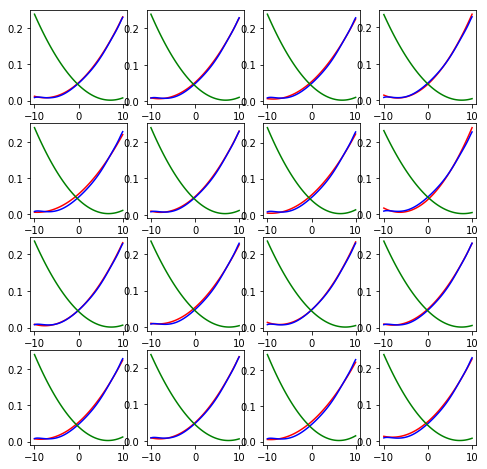

In [17]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y2[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y1[k],'g-')

We can see from the figure above, the training result for normal distribution parameters has high performance, so we test the model using some other normal distribution to check if the model can fit other kind of input data well.

In [ ]:
    a_ = np.random.normal(1, 7, 1)
    b_ = np.random.normal(3, 6, 1)
    c_ = np.random.normal(2, 5, 1)
    d_ = np.random.normal(4, 4, 1)
    e_ = np.random.normal(6, 3, 1)
    f_ = np.random.normal(5, 2, 1)

modified parameters above then test the model below:

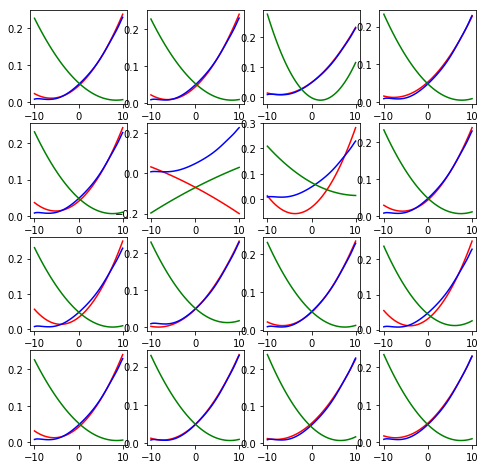

In [13]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,4):
    for j in range(0,4):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y2[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y1[k],'g-')

In most situation, the model maintain high performance with new normal distribution data. Then we try to change the normal distribution parameters to uniform distribution parameters.

In [ ]:
    a_ = np.random.uniform(1, 7, 1)
    b_ = np.random.uniform(3, 6, 1)
    c_ = np.random.uniform(2, 5, 1)
    d_ = np.random.uniform(4, 8, 1)
    e_ = np.random.uniform(5, 9, 1)
    f_ = np.random.uniform(6, 12, 1)

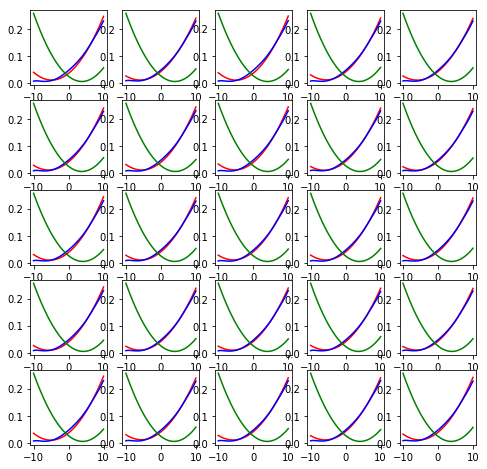

In [84]:
f_y3 = nor_y3
f_y4 = nor_y4
f_fit = nor_y3_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y3.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y4[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y3[k],'g-')

It still maintain high performance, what is make me excited, then we change the range of uniform distribution to each parameter like below:

In [ ]:
    a_ = np.random.uniform(-10, 0, 1)
    b_ = np.random.uniform(0, 5, 1)
    c_ = np.random.uniform(5, 10, 1)
    d_ = np.random.uniform(-10, -5, 1)
    e_ = np.random.uniform(-5, 0, 1)
    f_ = np.random.uniform(0, 10, 1)

And this time, the result becomes not that good as previous:

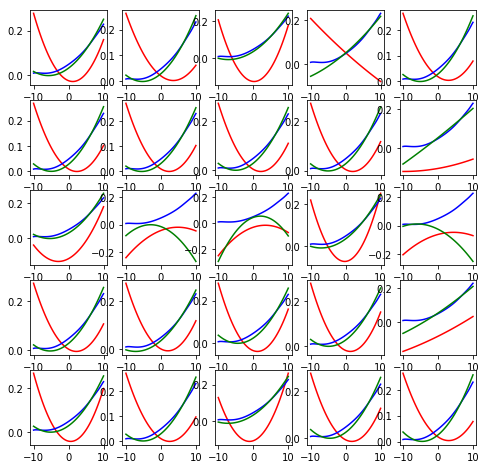

In [54]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

In general, it can still work, in the next steps, we want to figure out the relationship between the value of parameters and the test error for each data node.

We use callback() to save the best performed model,since the training datasize is large (1000000) and for each epoch the training time is pretty long, it is hard to run upto 100 epochs (cost about four days). So we set the "loss" as the monitor value, for each epoch, if the modified loss value is less than the existed model, it will save the new model to replace the previous one.   

In [ ]:
auto_test = create_model()
checkpointer = ModelCheckpoint("normal_batch_128", monitor='loss', verbose=0, save_best_only=True)
model1 = auto_test.fit(np.atleast_3d(nor_y1), np.atleast_3d(nor_y2), epochs= 100, batch_size=128,callbacks=[checkpointer])

The performance of the model generated by normal distribution data somehow is good, then we use the same way to generate the new model using uniform distribution data. Because the uniform distribution compared with normal distribution looks like more randomized in a specific range, so we generate 1000000 datasize for training.  

Firstly, we generate the uniform distribution parameter as below:

In [ ]:
    a_ = np.random.uniform(-12, -8, 1)
    b_ = np.random.uniform(-8, -4, 1)
    c_ = np.random.uniform(-4, 0, 1)
    d_ = np.random.uniform(0,4, 1)
    e_ = np.random.uniform(4, 8, 1)
    f_ = np.random.uniform(8, 12, 1)

After several epochs, we use the generated model test for the same type of data with size 10000.

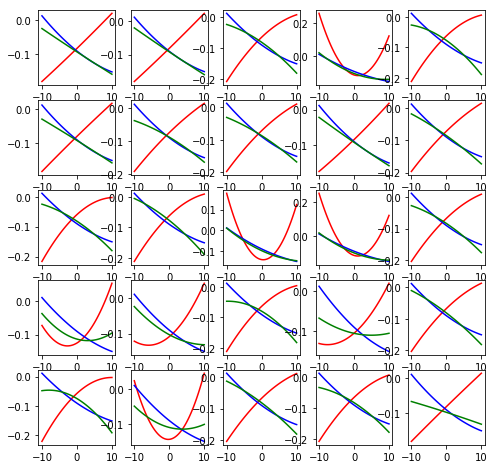

In [63]:
f_y7 = nor_y7
f_y8 = nor_y8
f_fit = nor_y7_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y7.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y7[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y8[k],'g-')

We can see that the model cannot fit the data very well compared with normal distribution model. And if we use the model test for the normal distribution data, the parameters are generated like below:

In [ ]:
    a_ = np.random.normal(1, 7, 1)
    b_ = np.random.normal(3, 6, 1)
    c_ = np.random.normal(2, 5, 1)
    d_ = np.random.normal(4, 4, 1)
    e_ = np.random.normal(6, 3, 1)
    f_ = np.random.normal(5, 2, 1)

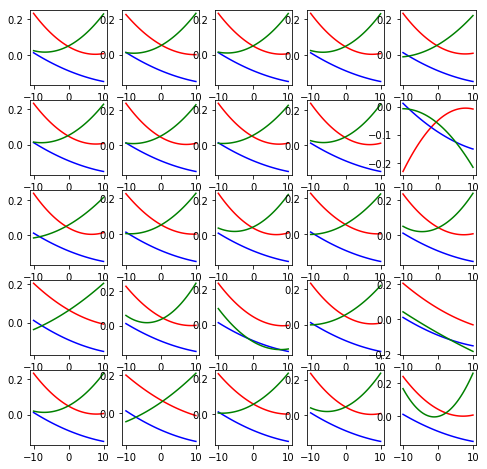

In [58]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y1[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y2[k],'g-')

It cannot fit.
And test for the different range of uniform distribution:

In [ ]:
    a_ = np.random.uniform(-10, 0, 1)
    b_ = np.random.uniform(0, 5, 1)
    c_ = np.random.uniform(5, 10, 1)
    d_ = np.random.uniform(-10, -5, 1)
    e_ = np.random.uniform(-5, 0, 1)
    f_ = np.random.uniform(0, 10, 1)

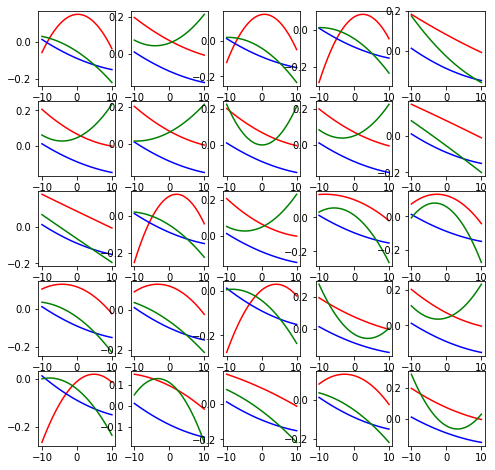

In [50]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

It still cannot fit. 
So we give up this model, and use shallow range of uniform distribution data below to training a new model and see if it can perform better. The training parameter distribution is:

In [ ]:
    a_ = np.random.uniform(-10, -8, 1)
    b_ = np.random.uniform(-8, -6, 1)
    c_ = np.random.uniform(-6, -4, 1)
    d_ = np.random.uniform(-4,-2, 1)
    e_ = np.random.uniform(-2, 0, 1)
    f_ = np.random.uniform(0, 2, 1)

We test the model use the new generated data with same distribution: 

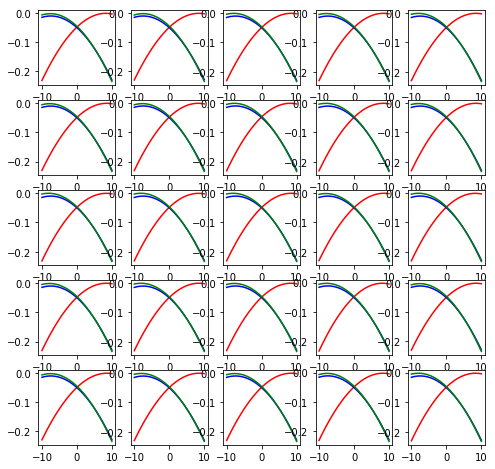

In [67]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

We can see that the model can perform well with the brand new datasize, then we test the model with normal distribution data as before:

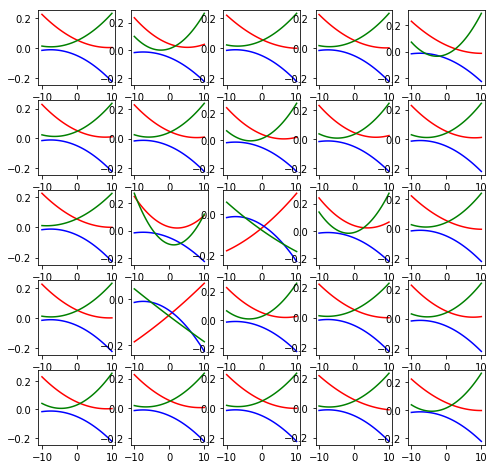

In [70]:
f_y1 = nor_y1
f_y2 = nor_y2
f_fit = nor_y1_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y1.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y1[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y2[k],'g-')

It sitll cannot fit, then we use new uniform distribution data test the model, and the data still not fit.

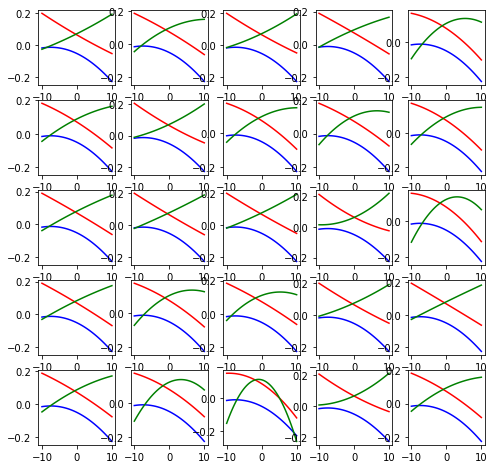

In [105]:
f_y7 = nor_y7
f_y8 = nor_y8
f_fit = nor_y7_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y7.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y7[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y8[k],'g-')

Then we enlarege the trianing datasize to 10 million to generate the model to see if the model can fit better. We use the parameter as uniform distribution with range 4.

In [ ]:
    a_ = np.random.uniform(-12, -8, 1)
    b_ = np.random.uniform(-8, -4, 1)
    c_ = np.random.uniform(-4, 0, 1)
    d_ = np.random.uniform(0, 4, 1)
    e_ = np.random.uniform(4, 8, 1)
    f_ = np.random.uniform(8, 12, 1)

We can have the conclusion that the model generted by uniform distribution data can hardly fit for other distributed data.

Then, we make another trial, use more complicated structure (power of 5) to trianing the model, we generate the functions as below, and use y1 to learn y2. Since y1 is more complicated than y2, and have more informations than y2. The training datasize is 1000000 and the parameters are normal distributed.

In [ ]:
def function_gen(x, a, b, c, d, e, z1, z2, z3, z4, z5, z7, z8, z9, z10):   
    y1 = a*(x-z1)**5 + b*(x-z2)**4 + c*(x-z3)**3 + d*(x-z4)**2 + e*(x-z5)
    y2 = a*(x+z7)**4 + b*(x+z8)**3 + c*(x+z9)**2 + d*(x+z10) + e
    return y1, y2

In [ ]:
a_ = np.random.normal(1, 5, 1)
b_ = np.random.normal(2, 4, 1)
c_ = np.random.normal(3, 3, 1)
d_ = np.random.normal(4, 2, 1)
e_ = np.random.normal(5, 1, 1)

The training data size is 1000000, we can see that when the input data has power of 5, the model cannot fit the test data well, we generate the the test data has the same distribtion as training data, the test data size is 10000.

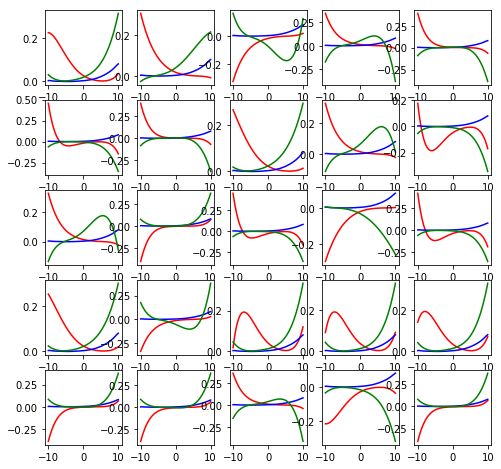

In [175]:
f_y5 = nor_y5
f_y6 = nor_y6
f_fit = nor_y5_result
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,5):
    for j in range(0,5):
        k = np.random.randint(0, f_y5.shape[0])
        ax = axs[i,j]
        ax.plot(x,f_y5[k],'r-')
        ax.plot(x,f_fit[k],'b-')
        ax.plot(x,f_y6[k],'g-')

Next, we want to figure out the relationship between the parameter value and the test error. Firstly, load the model(for this step, the model is normal distributed model we generate at the begining), then use the evaluate function to generate every test error for each dataset, we set the number of dataset to be 10000 here, then plot the figure of each parameter value with error.

In [ ]:
model_normal = load_model('auto_test_normal')
error = []
for k in range (100000):
    error_ = model_normal.evaluate(np.atleast_3d(nor_y1[k]), np.atleast_3d(nor_y2[k]),verbose = 0)
    error.append(error_)

We can see from the figures, the distribution of the points looks similar to each other. Now that we use the loss type is MSE(mean square error), we want to find the relationship between error and the parameter's variance for each single point. The distribution of the parameter is below:

In [ ]:
    a_ = np.random.normal(1, 7, 1)
    b_ = np.random.normal(3, 6, 1)
    c_ = np.random.normal(2, 5, 1)
    d_ = np.random.normal(4, 4, 1)
    e_ = np.random.normal(6, 3, 1)
    f_ = np.random.normal(5, 2, 1)

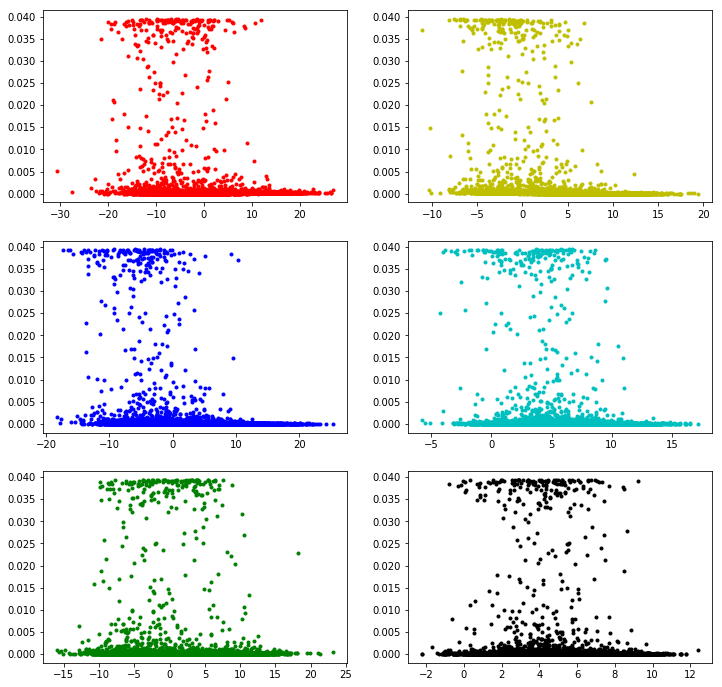

In [167]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(12,12))
axs[0,0].plot(a1,error1,'r.')
axs[1,0].plot(b1,error1,'b.')
axs[2,0].plot(c1,error1,'g.')
axs[0,1].plot(d1,error1,'y.')
axs[1,1].plot(e1,error1,'c.')
axs[2,1].plot(f1,error1,'k.')

In [ ]:
We can see that it obey the similar distribution.

In [ ]:
n_a = np.subtract(a,1)
s_a = np.power(n_a,2)
n_b = np.subtract(b,3)
s_b = np.power(n_b,2)
n_c = np.subtract(c,2)
s_c = np.power(n_c,2)
n_d = np.subtract(d,4)
s_d = np.power(n_d,2)
n_e = np.subtract(e,6)
s_e = np.power(n_e,2)
n_f = np.subtract(f,5)
s_f = np.power(n_f,2)

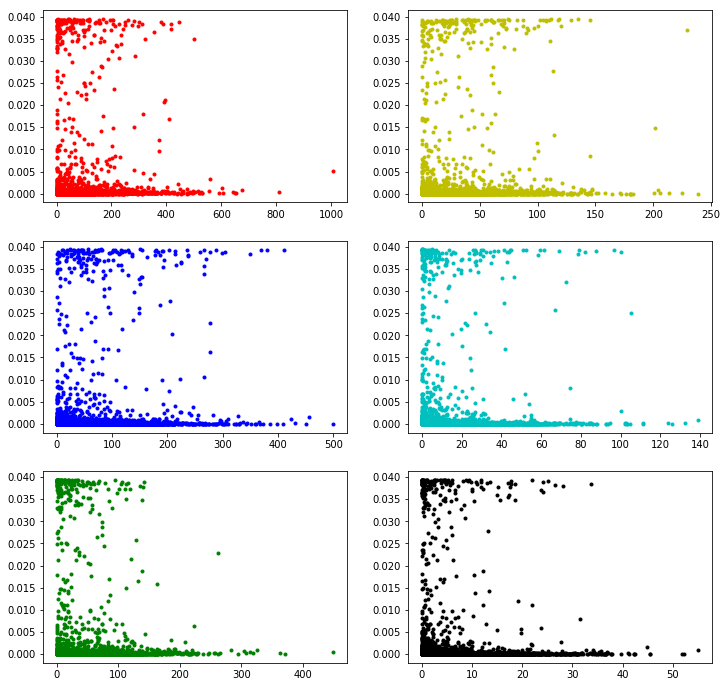

In [162]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(12,12))
axs[0,0].plot(s_a1,error1,'r.')
axs[1,0].plot(s_b1,error1,'b.')
axs[2,0].plot(s_c1,error1,'g.')
axs[0,1].plot(s_d1,error1,'y.')
axs[1,1].plot(s_e1,error1,'c.')
axs[2,1].plot(s_f1,error1,'k.')

If we set the training data size is 100000, the figures look like:

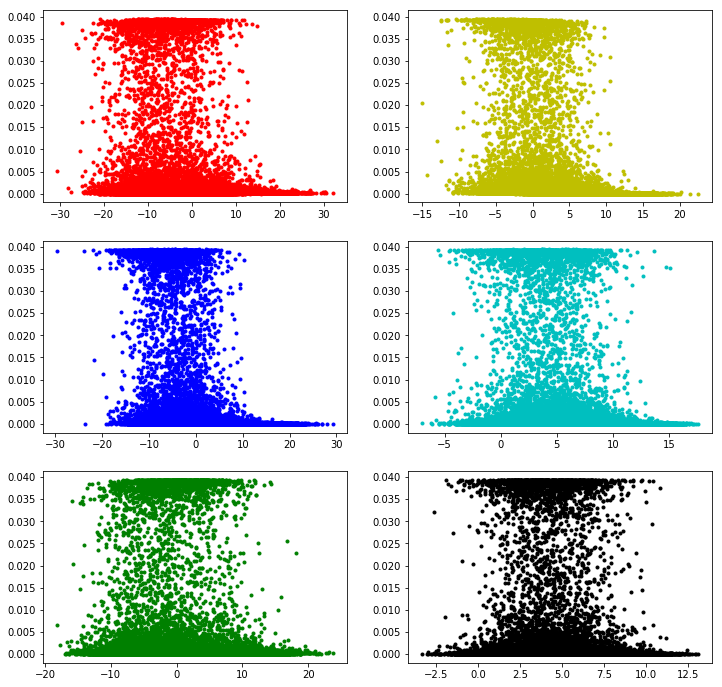

In [158]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(12,12))
axs[0,0].plot(a,error,'r.')
axs[1,0].plot(b,error,'b.')
axs[2,0].plot(c,error,'g.')
axs[0,1].plot(d,error,'y.')
axs[1,1].plot(e,error,'c.')
axs[2,1].plot(f,error,'k.')

The relationship between error and the parameter's variance

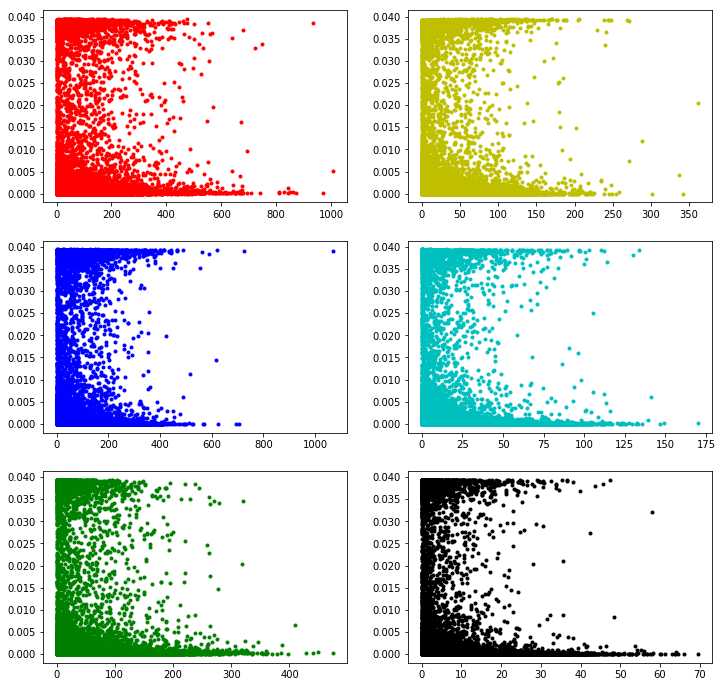

In [161]:
fig, axs = plt.subplots(ncols=2, nrows=3,figsize=(12,12))
axs[0,0].plot(s_a,error,'r.')
axs[1,0].plot(s_b,error,'b.')
axs[2,0].plot(s_c,error,'g.')
axs[0,1].plot(s_d,error,'y.')
axs[1,1].plot(s_e,error,'c.')
axs[2,1].plot(s_f,error,'k.')

Linear neural network model train on the same input data, we use other linear machine model to training the same type of data, and to compare that what model can fit the data best. The two models we use below are linear model and ridge regression model.

In [ ]:
regr = linear_model.LinearRegression()
prditY = regr.predict(nor_y1)

use the training data for testing

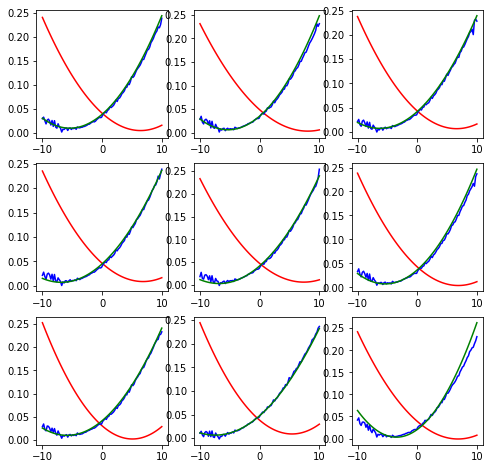

In [30]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y1[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y2[k],'g-')



generate new normal distribution data for testing

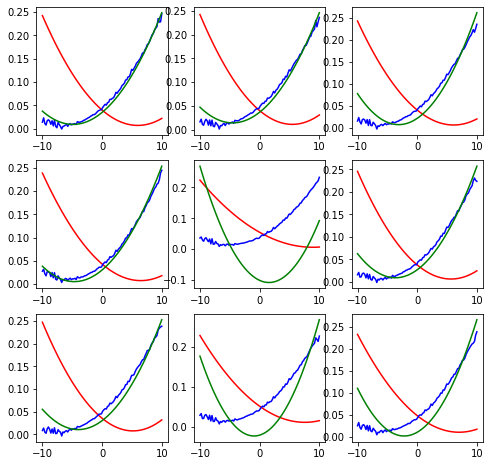

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y3[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y4[k],'g-')

generate uniform distribution data for testing

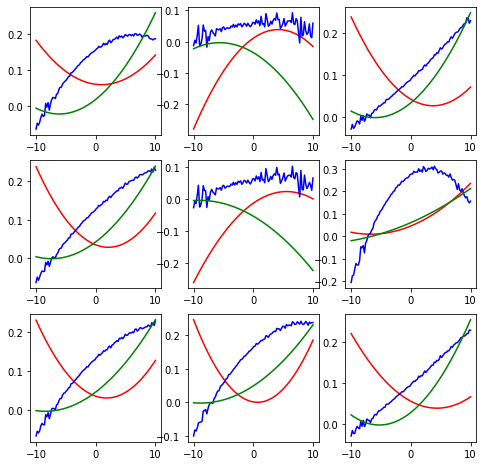

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y5[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y6[k],'g-')

In [ ]:
Ridge Regression, and we set the original alpha = 0.1:

In [ ]:
rr = Ridge(alpha=.01) 
rr.fit(nor_y1, nor_y2)
prditY = rr.predict(nor_y1)

In [ ]:
use the training data for testing

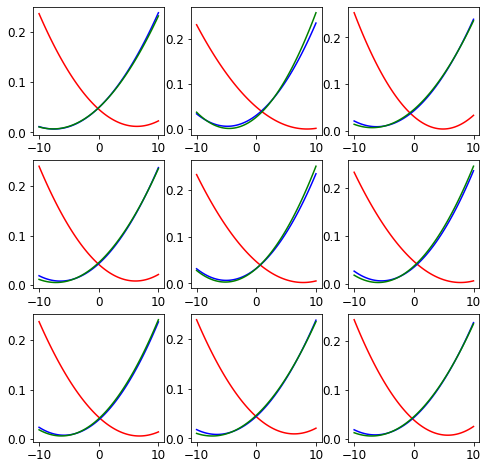

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y1[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y2[k],'g-')



In [ ]:
generate new normal distribution data for testing

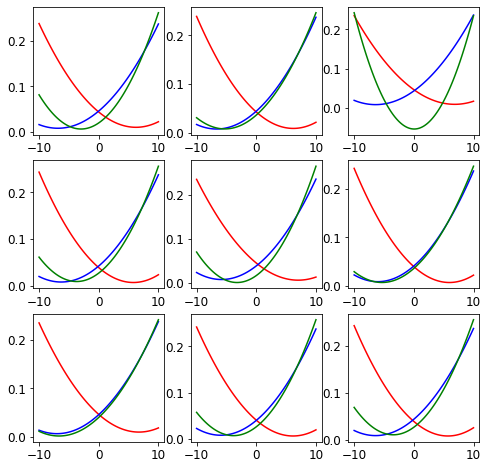

In [48]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y3[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y4[k],'g-')

In [ ]:
generate uniform distribution data for testing

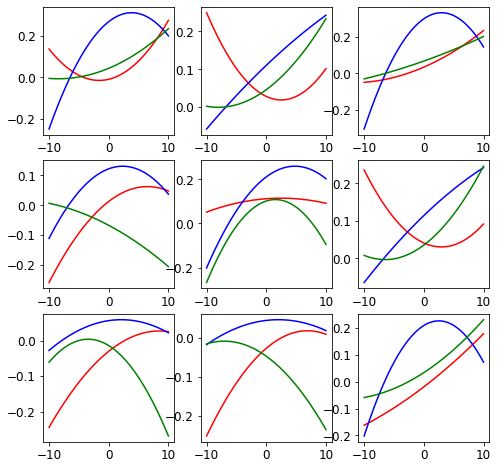

In [50]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,3):
    for j in range(0,3):
        k = np.random.randint(0, prditY.shape[0])
        ax = axs[i,j]
        ax.plot(x,nor_y5[k],'r-')
        ax.plot(x,prditY[k],'b-')
        ax.plot(x,nor_y6[k],'g-')